In [1]:
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
import gensim
from gensim.models import Word2Vec
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape,test.shape)
train.head()

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(31962, 3) (17197, 2)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [2]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

We have check already values for label 0, now we want to check values for label 1

In [3]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


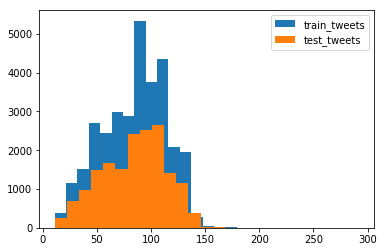

In [4]:
length_train = train["tweet"].str.len()
length_test = test["tweet"].str.len()
plt.hist(length_train, bins = 25, label = "train_tweets")
plt.hist(length_test, bins = 25, label = "test_tweets")
plt.legend()
plt.show()

The tweet-length distribution is more or less the same in both train and test data.

In [5]:
# Data Cleaning
dataset = train.append(test,ignore_index = True)
dataset.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


(49159, 3)

In [6]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, " ",input_txt)
    
    return input_txt

In [7]:
# Removing Twitter handles (@user)
dataset['tidy_tweet'] = np.vectorize(remove_pattern)(dataset['tweet'],'@[\w]*')
dataset.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so se...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause ...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [8]:
# Removing Punctuation numbers and  special chracters
dataset['tidy_tweet'] = dataset['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
dataset.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so se...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause ...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [9]:
# Removing short words
dataset['tidy_tweet'] = dataset['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataset.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [10]:
# Tokenizing the words and doing text_normalization
tokenized_tweet = dataset['tidy_tweet'].apply(lambda x: x.split()) # Tokenizing
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [11]:
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x]) # Stemming

In [12]:
# Combining tokens together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
dataset['tidy_tweet'] = tokenized_tweet

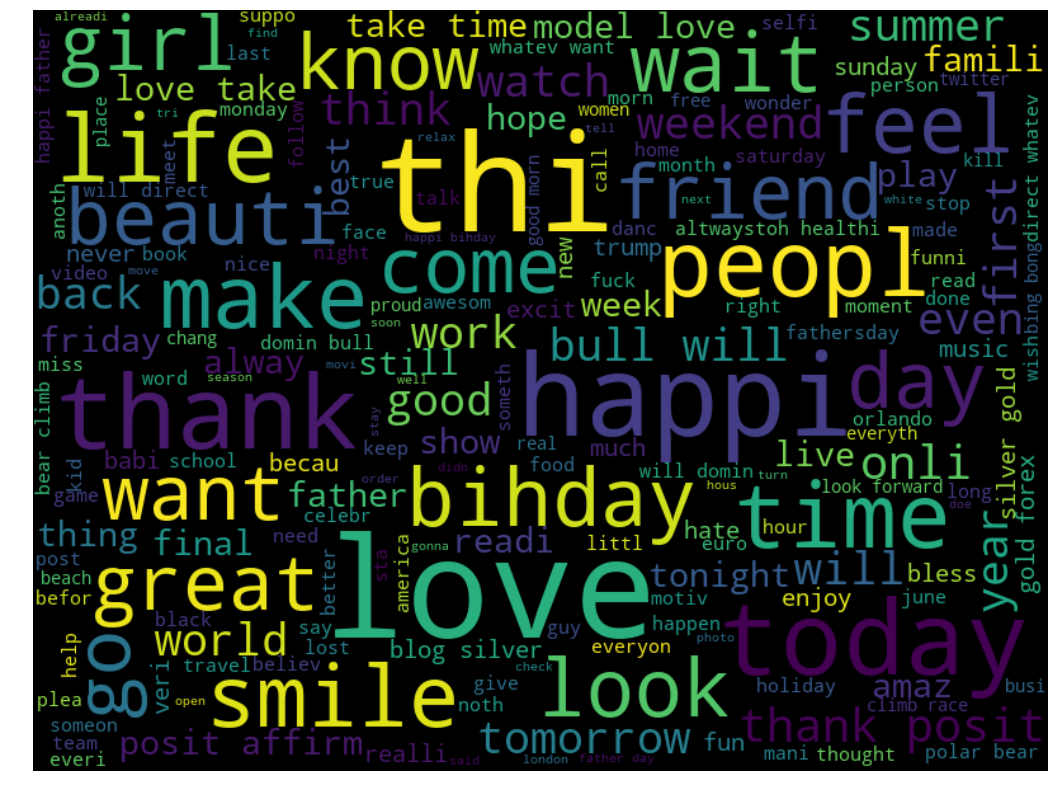

In [13]:
# visualize all the words our data using the wordcloud plot.
from wordcloud import WordCloud
all_words = ' '.join([text for text in dataset['tidy_tweet']])
wordcloud = WordCloud(width = 800,height = 600, random_state = 21, max_font_size = 110).generate(all_words)
plt.figure(figsize = (20,14))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

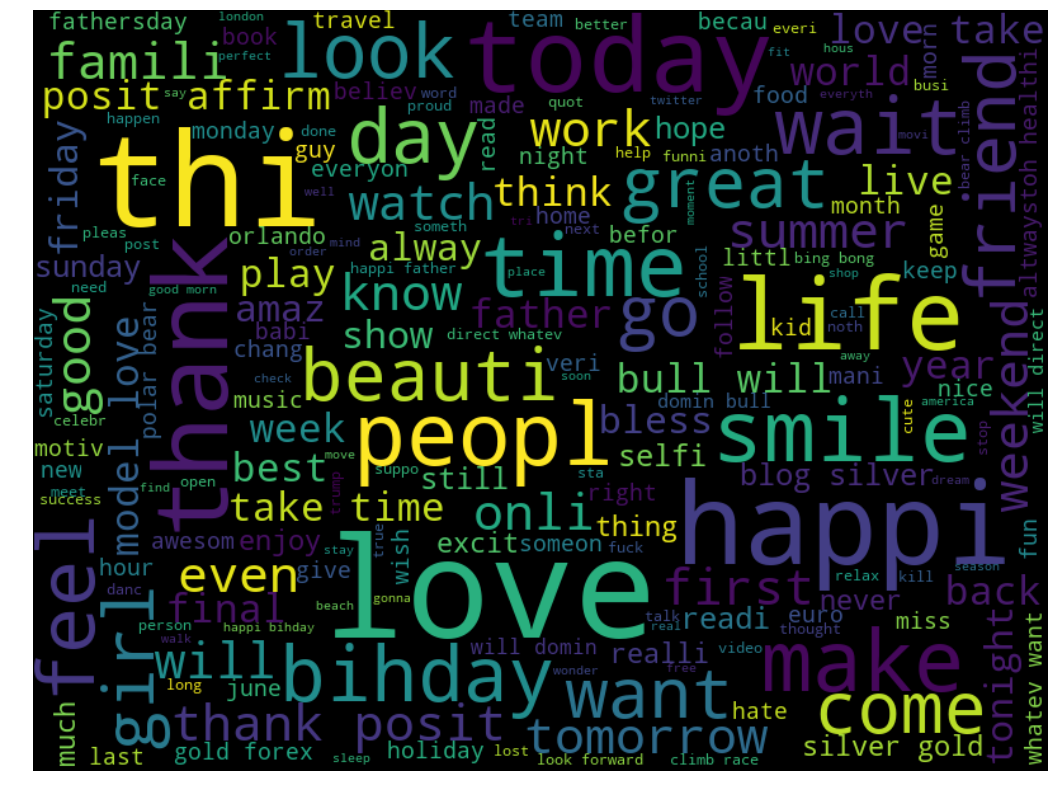

In [17]:
# Words in non -racist/sexist tweets
normal_words = ' '.join([text for text in dataset['tidy_tweet'][dataset['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 600,random_state = 21,max_font_size = 110).generate(normal_words)
plt.figure(figsize = (20,14))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

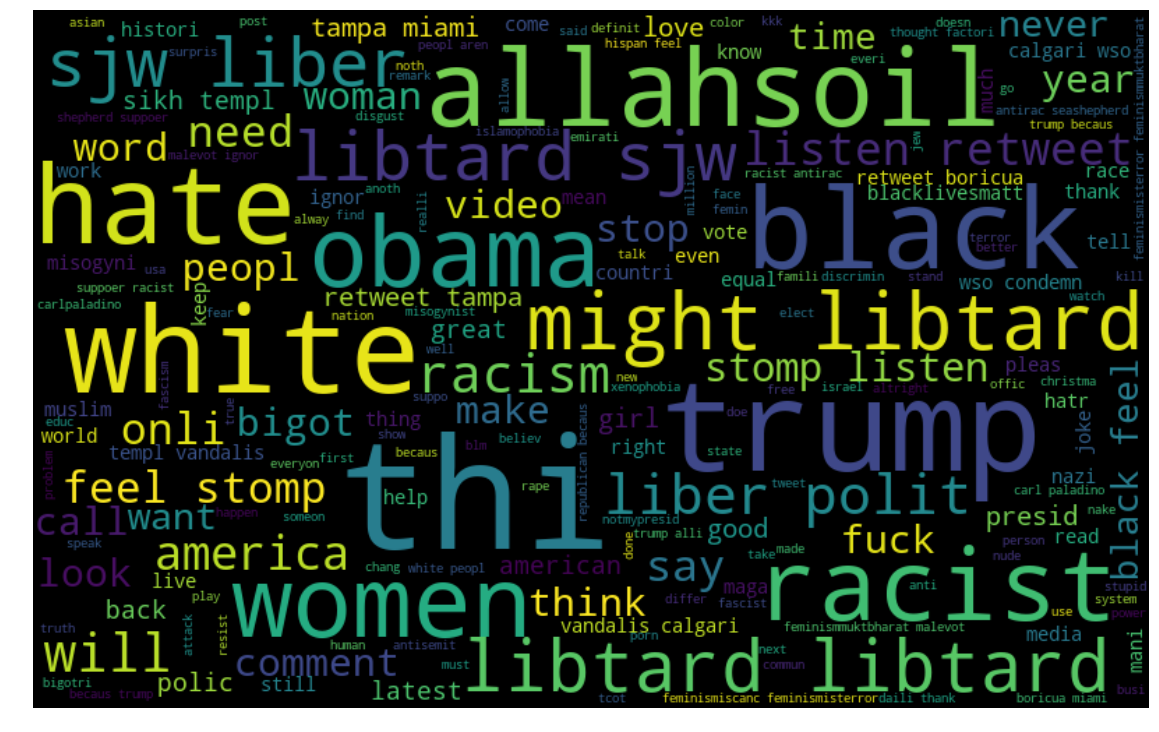

In [19]:
# Racisit and sexist tweets
negative_words = ' '.join([text for text in dataset['tidy_tweet'][dataset['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110, random_state = 21).generate(negative_words)
plt.figure(figsize = (20,15))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [20]:
# Understand the impact of Hashtags on tweet sentiments
def hashtag_extract(x): # Function to collect hashtags
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    return hashtags

In [24]:
# Extract hashtags from non-racist/sexist tweets
HT_regular = hashtag_extract(dataset['tidy_tweet'][dataset['label']==0])
# Extracting hashtags for racist and sexist tweets
HT_negative = hashtag_extract(dataset['tidy_tweet'][dataset['label']==1])

# Un-nesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top 'n' hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

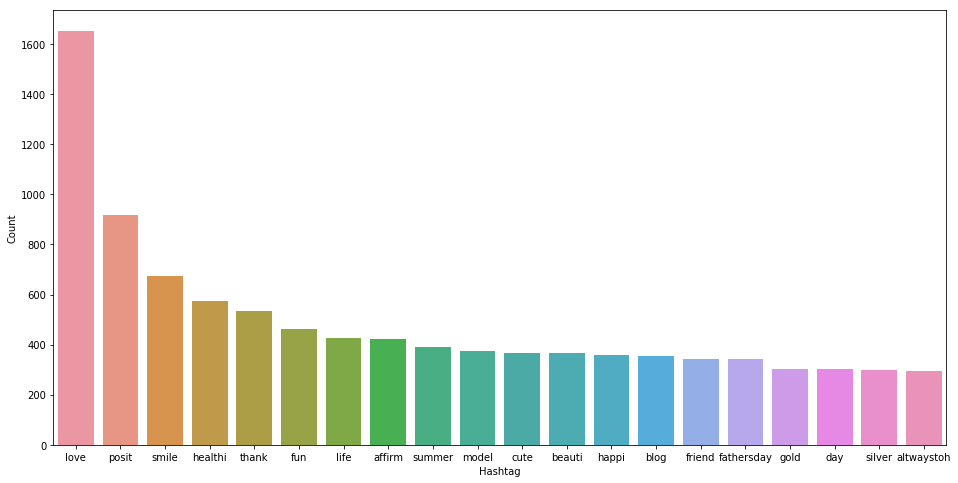

In [25]:
# Non-Racist/Sexist Tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                 'Count': list(a.values())})
# Selecting top 20 most frequent hashtags
d = d.nlargest(columns = "Count",  n= 20)
plt.figure(figsize = (16,8))
ax = sns.barplot(data = d, x = "Hashtag",y = "Count")
ax.set(ylabel = "Count")
plt.show()

All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list.
Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

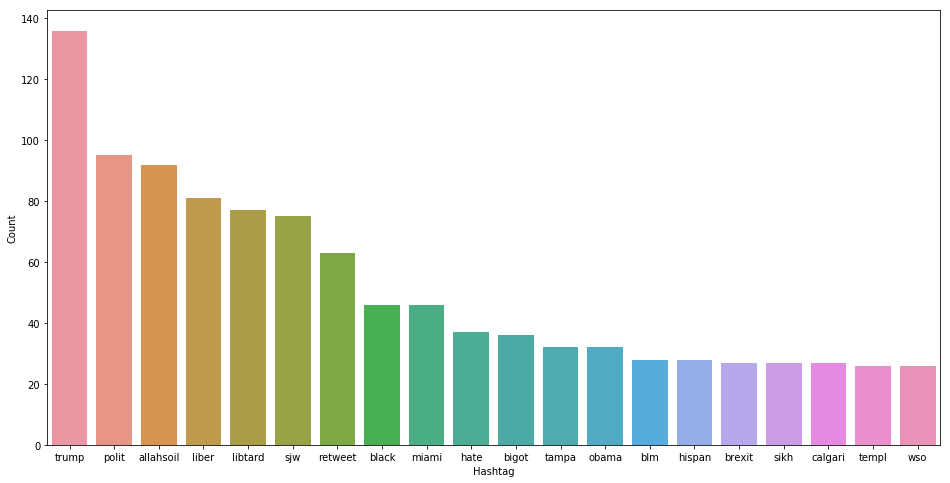

In [26]:
# Racist and Sexist Tweets
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                 "Count": list(a.values())})
# Selecting top 20 most frequent hashtags
d = d.nlargest(columns = "Count", n = 20)
plt.figure(figsize = (16,8))
ax = sns.barplot(data = d, x = "Hashtag", y = "Count")
ax.set(ylabel = "Count")
plt.show()

As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep 
these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

In [27]:
# Extracting features from Cleaned Tweets
# Bag of Words Model
bow_vectorizer = CountVectorizer(max_df = 0.90,min_df = 2, max_features = 1000, stop_words = 'english')
bow = bow_vectorizer.fit_transform(dataset['tidy_tweet'])
bow.shape

(49159, 1000)

In [28]:
# TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(dataset['tidy_tweet'])
tfidf.shape

(49159, 1000)

# Word Embedding

In [29]:
#Word2Vec Embedding
tokenized_tweet = dataset['tidy_tweet'].apply(lambda x: x.split()) # Tokenizing
model = Word2Vec(tokenized_tweet, size = 500,window = 5,min_count = 2, sg = 1,hs = 0, negative = 10, workers = 2,
                 seed = 34 )
model.train(tokenized_tweet,total_examples =  len(dataset['tidy_tweet']), epochs = 20)

(6510028, 7536020)

In [30]:
model.most_similar(positive = "similar")

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('stoop', 0.6717727184295654),
 ('misogyni', 0.6675853729248047),
 ('anni', 0.6586470603942871),
 ('robbi', 0.6500284671783447),
 ('#yellen', 0.6495875716209412),
 ('toll', 0.64593505859375),
 ('nought', 0.6442731618881226),
 ('breitba', 0.6440730094909668),
 ('#macedonia', 0.6435890793800354),
 ('lethal', 0.6423858404159546)]

In [31]:
model.most_similar(positive = "trump")

C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.5357903242111206),
 ('phoni', 0.5115228891372681),
 ('melo', 0.5020608901977539),
 ('hillari', 0.5007722973823547),
 ('#delegaterevolt', 0.499028742313385),
 ('unstabl', 0.4985562562942505),
 ('unfit', 0.493768572807312),
 ('tomlin', 0.4912082850933075),
 ('potu', 0.4868161678314209),
 ('unfavor', 0.48615097999572754)]

In [32]:
model["food"]

array([ 0.04602212,  0.02698662, -0.2459531 , -0.30425334, -0.09455663,
        0.25538093, -0.3155513 ,  0.24178036,  0.24184181,  0.20765868,
       -0.10997134,  0.41257426,  0.35612813,  0.01133415, -0.02421711,
       -0.16015954,  0.47268018, -0.38473415,  0.12283604,  0.3739846 ,
       -0.11421479,  0.26372978,  0.1259553 , -0.36093283,  0.040136  ,
       -0.3980385 ,  0.28753394,  0.25669459,  0.04446913, -0.4574981 ,
       -0.03064901, -0.17952284,  0.23869282, -0.157851  , -0.01427464,
        0.08797985,  0.26226524, -0.15663128, -0.1657365 ,  0.11423727,
       -0.04739714, -0.13571611,  0.1445542 ,  0.5346238 ,  0.435417  ,
       -0.06058405,  0.07752421, -0.03641832, -0.20524353,  0.20064655,
        0.19852765, -0.83454573,  0.14695086,  0.11045501,  0.42159468,
        0.16731182, -0.18804936,  0.07224367,  0.12669039, -0.4120505 ,
       -0.23644036,  0.20647748, -0.22129297, -0.0490425 , -0.33730644,
        0.07462785,  0.19165139,  0.22697367,  0.30235   ,  0.14

In [33]:
len(model["food"])

500

# Preparing vectors for tweets

We will use the below function to create a vector for each tweet by taking the average of the vectors
of the words present in the tweet.

In [36]:
def word_vector(tokens,size):
    vec = np.zeros(size).reshape((1,size))
    count = 0
    for word in tokens:
        try:
            vec +=model[word].reshape((1, size))
            count += 1
        except KeyError:
            continue
        if count != 0:
            vec /= 0
        return vec

In [37]:
# Preparing Word2Vec Feature set
word2vec_arrays = np.zeros((len(tokenized_tweet), 500))

for i in range(len(tokenized_tweet)):
    word2vec_arrays[i,:] = word_vector(tokenized_tweet[i], 500)

word2vec_df = pd.DataFrame(word2vec_arrays)
word2vec_df.shape    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(49159, 500)

# Doc2Vec Embedding

In [38]:
from tqdm import tqdm
tqdm.pandas(desc = "progress-bar")
from gensim.models.doc2vec import LabeledSentence

To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. 
We can do so by using Gensim’s LabeledSentence() function.

In [39]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index,twt):
        output.append(LabeledSentence(s,["tweet_"+str(i)]))
    return output    

In [40]:
labeled_tweets = add_label(tokenized_tweet) #label all the tweet

In [41]:
labeled_tweets[:6] # Lets look at the result

[LabeledSentence(words=['when', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'into', 'dysfunct', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thank', '#lyft', 'credit', 'caus', 'they', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesti'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguid', 'societi', '#motiv'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talk', 'befor', 'they', 'leav', 'chao', 'disput', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [43]:
from gensim.models import Doc2Vec
model_d2v = Doc2Vec(dm = 1,dm_mean = 1, size = 500, window = 5, negative = 7, min_count = 5,workers = 3,alpha = 0.1, seed =23)
model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|████████████████████████████████| 49159/49159 [00:00<00:00, 372394.56it/s]


In [44]:
model_d2v.train(labeled_tweets,total_examples = len(dataset["tidy_tweet"]), epochs = 15)

In [46]:
# Preparing doc2vec feature set
docvec_arrays = np.zeros((len(tokenized_tweet), 500))
for i in range(len(dataset)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,500))

docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 500)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# Bag of words feature
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]
# Splitting the data inot training and validation set
text_train,test_train,sent_train,sent_test = train_test_split(train_bow, train['label'], random_state = 42,test_size = 0.3)

In [50]:
logreg = LogisticRegression()
logreg.fit(text_train,sent_train) # Training the model
prediction = logreg.predict_proba(test_train)  # predicting on the valid set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int)
f1_score(sent_test,prediction_int)

0.5307820299500832

Now let's make predictions for the test dataset and create a submission file.

In [51]:
test_pred = logreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >=0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_logreg_bow.csv',index = False) # Writing data to csv file

In [52]:
# TF-IDF features
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]
text_train,text_test,sent_train,sent_test = train_test_split(train_tfidf,train['label'], random_state = 42, test_size = 0.3)
logreg.fit(text_train,sent_train)
prediction = logreg.predict_proba(test_train)  # predicting on the valid set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0 
prediction_int = prediction_int.astype(np.int)
f1_score(sent_test,prediction_int)

0.5243101182654402